In [64]:
import pandas as pd, xarray as xr, numpy as np, matplotlib.pyplot as plt, sklearn as sk, scipy

In [65]:
#Load in feature and label data
features = pd.read_csv('C:/users/benja/downloads/ORIE4741/all_feature_data.csv')
labels = pd.read_csv('C:/users/benja/downloads/ORIE4741/all_label_data.csv')
features = features.drop(columns = ['Unnamed: 0'])
labels = labels.drop(columns = ['Unnamed: 0'])

In [66]:
#Remove data points with more than half of features missing
dropidxs = []
for i in range(features.shape[0]):
  if pd.isnull(features).sum(axis = 1)[i] > 0.5*features.shape[1]:
    dropidxs.append(i)
print('Dropping ' + str(len(dropidxs)) + ' data points due to missing data')

features = features.drop(index = dropidxs).reset_index(drop=True)
labels = labels.drop(index = dropidxs).reset_index(drop=True)

Dropping 75 data points due to missing data


In [67]:
features = features[labels['sknt'] > 40]
labels = labels[labels['sknt'] > 40]

In [68]:
features.reset_index(drop=True, inplace=True)

In [69]:
labels.reset_index(drop=True, inplace=True)

Train/Test/Validate Split

In [70]:
from numpy import random
#Set random seed for reproducible results
np.random.seed(1)

In [71]:
#Randomly select indices for training and testing data

other_indices = []
test_indices = []
validate_indices = []
train_indices = []

while len(train_indices) < int(np.round(features.shape[0] * 0.6)):
  i = np.random.randint(0, features.shape[0])
  if i not in train_indices:
    train_indices.append(i)

for i in range(features.shape[0]):
  if i not in train_indices:
    other_indices.append(i)

while len(validate_indices) < int(np.round(len(other_indices) * 0.5)):
  i = np.random.randint(0, len(other_indices))
  if other_indices[i] not in validate_indices:
    validate_indices.append(other_indices[i])

for i in range(len(other_indices)):
  if other_indices[i] not in validate_indices:
    test_indices.append(other_indices[i])


train_indices = np.array(train_indices)
validate_indices = np.array(validate_indices)
test_indices = np.array(test_indices)

train_and_validate_indices = []
train_and_validate_indices.extend(train_indices)
train_and_validate_indices.extend(validate_indices)

Standardize Data

In [72]:
#Split into training and testing features and labels
training_features_array = features.iloc[train_indices].values
training_labels_array = labels.iloc[train_indices, 1:].values
validate_features_array = features.iloc[validate_indices].values
validate_labels_array = labels.iloc[validate_indices, 1:].values
testing_features_array = features.iloc[test_indices].values
testing_labels_array = labels.iloc[test_indices, 1:].values

#Standardize data
from sklearn.preprocessing import StandardScaler
all_features_array_scaled = StandardScaler().fit(np.array(features)).transform(np.array(features))

training_features_array_scaled = all_features_array_scaled[train_indices, :]
validate_features_array_scaled = all_features_array_scaled[validate_indices, :]
testing_features_array_scaled = all_features_array_scaled[test_indices, :]

0.5893101507579177
0.5835108392860437


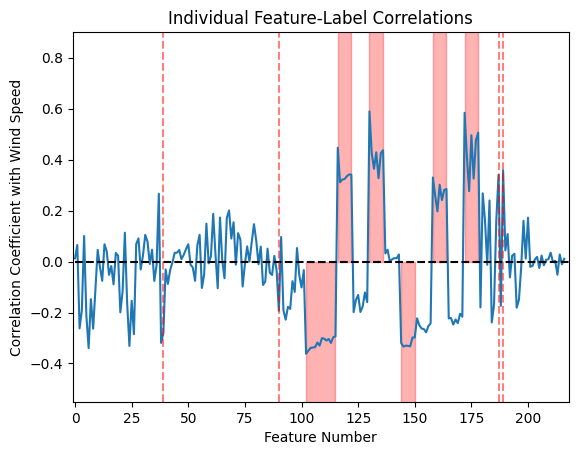

In [73]:
all_ccs = []
for i in range(features.shape[1]):
  all_ccs.append(np.corrcoef(features.iloc[:, i], labels['sknt'])[0][1])

plt.plot(all_ccs)
print(max(all_ccs))
print(np.corrcoef(features['ws8001'], labels['sknt'])[0][1])
plt.xlabel('Feature Number')
plt.ylabel('Correlation Coefficient with Wind Speed')
plt.title('Individual Feature-Label Correlations')

plt.ylim([-0.55, 0.9])
plt.xlim([-1, 218])
plt.plot([0, 218], [0, 0], '--k')
plt.plot([39, 39], [-0.55, 0.9], c = 'r', linestyle = '--', alpha = 0.5) #t80026
plt.plot([90, 90], [-0.55, 0.9], c = 'r', linestyle = '--', alpha = 0.5) #tsfc76
#plt.plot([102, 102], [-0.55, 0], c = 'red', linestyle = '--')
#plt.plot([115, 115], [-0.55, 0], c = 'red', linestyle = '--')
plt.fill_betweenx([-1, 0], 102, 115, color = 'r', alpha = 0.3) #tsfc/tdsfc

#plt.plot([116, 116], [0, 1], c = 'red', linestyle = '--')
#plt.plot([122, 122], [0, 1], c = 'red', linestyle = '--')
plt.fill_betweenx([0, 1], 116, 122, color = 'r', alpha = 0.3) #usfc

plt.fill_betweenx([0, 1], 130, 136, color = 'r', alpha = 0.3) #wssfc

plt.fill_betweenx([-1, 0], 144, 150, color = 'r', alpha = 0.3) #t800

plt.fill_betweenx([0, 1], 158, 164, color = 'r', alpha = 0.3) #u800

plt.fill_betweenx([0, 1], 172, 178, color = 'r', alpha = 0.3) #u800

plt.plot([187, 187], [-0.55, 0.9], c = 'r', linestyle = '--', alpha = 0.5)#ws5am

plt.plot([189, 189], [-0.55, 0.9], c = 'r', linestyle = '--', alpha = 0.5)#gust5am
#


Single Predictor OLS

In [74]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

#Fit OLS model, find cross validation mean and stdev R squared
one_pred_OLS = LinearRegression().fit(features.iloc[train_and_validate_indices]['ws8001'].values.reshape(-1, 1), labels.iloc[train_and_validate_indices]['sknt'].values.reshape(-1, 1))
one_pred_OLS_cv = cross_val_score(one_pred_OLS, features.iloc[train_and_validate_indices]['ws8001'].values.reshape(-1, 1), labels.iloc[train_and_validate_indices]['sknt'].values.reshape(-1, 1))
one_pred_OLS_trainonly = LinearRegression().fit(features.iloc[train_indices]['ws8001'].values.reshape(-1, 1), labels.iloc[train_indices]['sknt'].values.reshape(-1, 1))
one_pred_OLS_validscore = one_pred_OLS_trainonly.score(features.iloc[validate_indices]['ws8001'].values.reshape(-1, 1), labels.iloc[validate_indices]['sknt'].values.reshape(-1, 1))

print(("Cross-validation mean R squared: " + str(one_pred_OLS_cv.mean())))
print(("Cross-validation stdev R squared: " + str(one_pred_OLS_cv.std())))
print(("Validation set R squared is: " + str(one_pred_OLS_validscore)))

Cross-validation mean R squared: 0.358954846474046
Cross-validation stdev R squared: 0.07935742145789429
Validation set R squared is: 0.3883383060310661


Text(0.5, 1.0, 'Single-predictor OLS Predicted vs. Actual Wind Speed')

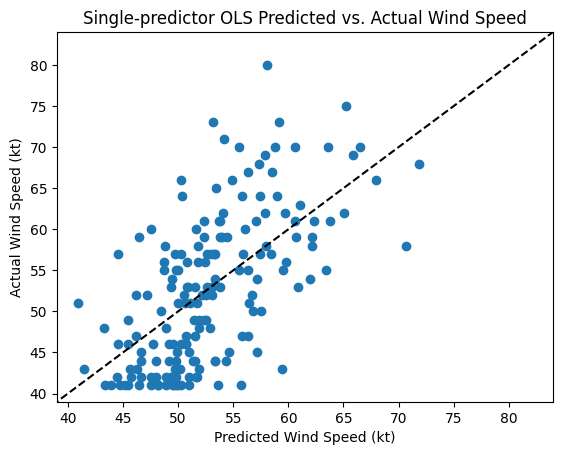

In [75]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

#Plot model predictions vs actual for test set
one_pred_OLS = LinearRegression().fit(features.iloc[train_indices]['ws8001'].values.reshape(-1, 1), labels.iloc[train_indices]['sknt'].values.reshape(-1, 1))
one_pred_OLS_predictions = one_pred_OLS.predict(features.iloc[validate_indices]['ws8001'].values.reshape(-1, 1))

plt.scatter(one_pred_OLS_predictions, labels.iloc[validate_indices]['sknt'].values.reshape(-1, 1))
plt.plot([0, 85], [0, 85], '--k')
plt.ylim([39, 84])
plt.xlim([39, 84])


plt.xlabel('Predicted Wind Speed (kt)')
plt.ylabel('Actual Wind Speed (kt)')
plt.title('Single-predictor OLS Predicted vs. Actual Wind Speed')

All-Predictors Linear Model for Non-Standardized Data

In [76]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

#Run OLS for all features, print cross validation mean and stdev (5 fold)
multi_pred_unscaled_OLS = LinearRegression().fit(features.iloc[train_and_validate_indices].values, labels.iloc[train_and_validate_indices]['sknt'].values.reshape(-1, 1))
multi_pred_unscaled_OLS_cv = cross_val_score(multi_pred_unscaled_OLS, features.iloc[train_and_validate_indices].values, labels.iloc[train_and_validate_indices]['sknt'].values.reshape(-1, 1))
multi_pred_unscaled_OLS_trainonly = LinearRegression().fit(features.iloc[train_indices].values, labels.iloc[train_indices]['sknt'].values.reshape(-1, 1))
multi_pred_unscaled_OLS_validscore = multi_pred_unscaled_OLS_trainonly.score(features.iloc[validate_indices].values, labels.iloc[validate_indices]['sknt'].values.reshape(-1, 1))


print(("Cross-validation mean R squared: " + str(multi_pred_unscaled_OLS_cv.mean())))
print(("Cross-validation stdev R squared: " + str(multi_pred_unscaled_OLS_cv.std())))
print(("Validation set R squared is: " + str(multi_pred_unscaled_OLS_validscore)))

Cross-validation mean R squared: 0.45827075366575476
Cross-validation stdev R squared: 0.07442209025335808
Validation set R squared is: 0.3866327564598965


Text(0.5, 1.0, 'All-predictor OLS Predicted vs. Actual Wind Speed \n Non-Standardized Features')

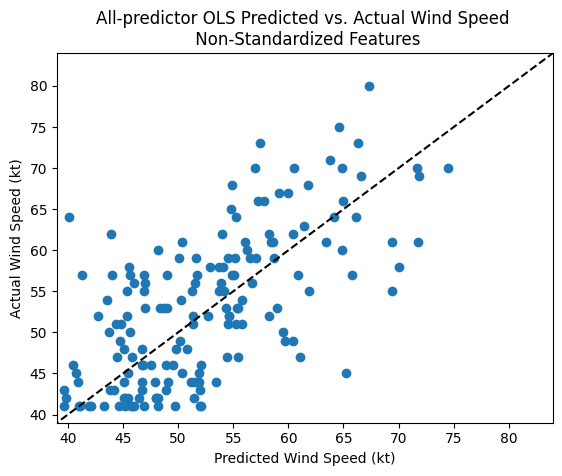

In [77]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

multi_pred_unscaled_OLS = LinearRegression().fit(features.iloc[train_indices].values, labels.iloc[train_indices]['sknt'].values.reshape(-1, 1))
multi_pred_unscaled_OLS_predictions = multi_pred_unscaled_OLS.predict(features.iloc[validate_indices].values)

plt.scatter(multi_pred_unscaled_OLS_predictions, labels.iloc[validate_indices]['sknt'].values.reshape(-1, 1))
plt.plot([0, 85], [0, 85], '--k')
plt.ylim([39, 84])
plt.xlim([39, 84])


plt.xlabel('Predicted Wind Speed (kt)')
plt.ylabel('Actual Wind Speed (kt)')
plt.title('All-predictor OLS Predicted vs. Actual Wind Speed \n Non-Standardized Features')

All-Predictors Linear Model for Standardized Data

In [78]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

multi_pred_OLS_standardized = LinearRegression().fit(all_features_array_scaled[train_and_validate_indices, :], labels.iloc[train_and_validate_indices]['sknt'].values.reshape(-1, 1))
multi_pred_OLS_standardized_cv = cross_val_score(multi_pred_OLS_standardized, all_features_array_scaled[train_and_validate_indices, :], labels.iloc[train_and_validate_indices]['sknt'].values.reshape(-1, 1))
multi_pred_OLS_standardized_trainonly = LinearRegression().fit(all_features_array_scaled[train_indices, :], labels.iloc[train_indices]['sknt'].values.reshape(-1, 1))
multi_pred_OLS_standardized_validscore = multi_pred_OLS_standardized_trainonly.score(all_features_array_scaled[validate_indices, :], labels.iloc[validate_indices]['sknt'].values.reshape(-1, 1))

print(("Cross-validation mean R squared: " + str(multi_pred_OLS_standardized_cv.mean())))
print(("Cross-validation stdev R squared: " + str(multi_pred_OLS_standardized_cv.std())))
print(("Validation set R squared is: " + str(multi_pred_OLS_standardized_validscore)))

Cross-validation mean R squared: 0.459230147211819
Cross-validation stdev R squared: 0.07394837954465719
Validation set R squared is: 0.3857315974973581


In [79]:
a = np.zeros(len(all_features_array_scaled[test_indices, :][0]))
a[5] = 1
a

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [80]:
multi_pred_OLS_standardized.predict(all_features_array_scaled[test_indices[0], :].reshape(1, -1))

array([[44.07877813]])

In [81]:
multi_pred_OLS_standardized.predict((all_features_array_scaled[test_indices[0], :] + a).reshape(1, -1))

array([[-4.16109292e+09]])

Text(0.5, 1.0, 'All-predictor OLS Predicted vs. Actual Wind Speed \n Standardized Features')

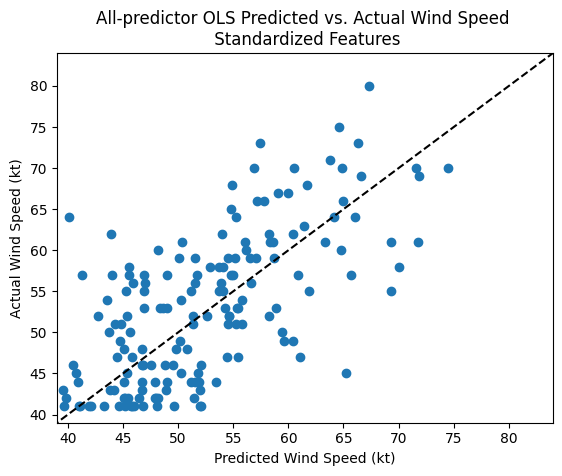

In [82]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

multi_pred_OLS_standardized = LinearRegression().fit(all_features_array_scaled[train_indices], labels.iloc[train_indices]['sknt'].values.reshape(-1, 1))
multi_pred_OLS_standardized_predictions = multi_pred_OLS_standardized.predict(all_features_array_scaled[validate_indices])

plt.scatter(multi_pred_OLS_standardized_predictions, labels.iloc[validate_indices]['sknt'].values.reshape(-1, 1))
plt.plot([0, 85], [0, 85], '--k')
plt.ylim([39, 84])
plt.xlim([39, 84])


plt.xlabel('Predicted Wind Speed (kt)')
plt.ylabel('Actual Wind Speed (kt)')
plt.title('All-predictor OLS Predicted vs. Actual Wind Speed \n Standardized Features')

Text(0.5, 1.0, 'All-Feature OLS with Standardized Data: \n Coefficient Magnitudes')

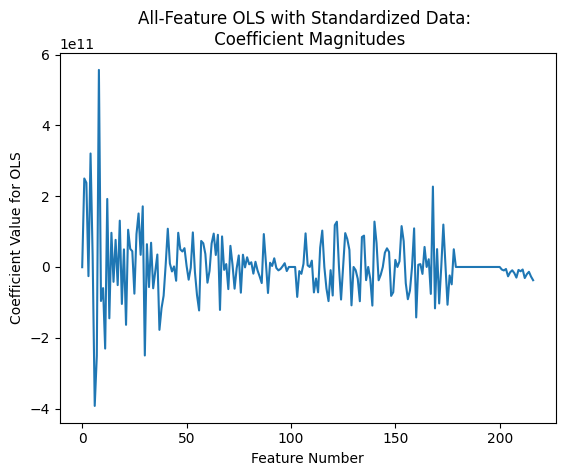

In [83]:
plt.plot(multi_pred_OLS_standardized.coef_[0])
plt.xlabel('Feature Number')
plt.ylabel('Coefficient Value for OLS')
plt.title('All-Feature OLS with Standardized Data: \n Coefficient Magnitudes')

In [84]:
#Do bootstrap to estimate prediction variance
bootstrap_pred_scores = []
bootstrap_w = []
for iter in range(50):
  bootstrap_indices = []
  for i in range(int(round(len(train_indices) / 2))):
    bootstrap_indices.append(train_indices[np.random.randint(0, len(train_indices))])
  bootstrap_indices = np.array(bootstrap_indices)
  multi_pred_OLS_standardized = LinearRegression().fit(all_features_array_scaled[bootstrap_indices, :], labels.iloc[bootstrap_indices]['sknt'].values.reshape(-1, 1))
  score = multi_pred_OLS_standardized.score(all_features_array_scaled[validate_indices, :], labels.iloc[validate_indices]['sknt'].values.reshape(-1, 1))
  w = multi_pred_OLS_standardized.coef_[0]
  bootstrap_pred_scores.append(score)
  bootstrap_w.append(w)
  
print('Mean of bootstrapped R squared is: ' + str(np.array(bootstrap_pred_scores).mean()))
print('StDev of bootstrapped R squared is: ' + str(np.array(bootstrap_pred_scores).std()))

Mean of bootstrapped R squared is: -9.965073170779639e+22
StDev of bootstrapped R squared is: 5.042998189789962e+23


In [85]:
np.array(bootstrap_w).std(axis = 0)

array([6.45863450e+13, 5.44776937e+13, 5.73109997e+13, 6.50548072e+13,
       1.71170993e+13, 3.51960770e+13, 2.52557347e+13, 1.07193921e+13,
       1.70791365e+13, 6.40333063e+12, 1.22438809e+13, 1.26764957e+13,
       1.16639777e+13, 1.35496474e+13, 1.15390284e+13, 1.47008114e+13,
       8.62456562e+12, 1.22127159e+13, 1.12515975e+13, 1.21685555e+13,
       1.21192231e+13, 1.32624291e+13, 1.38337849e+13, 1.18739401e+13,
       1.35460259e+13, 1.01369224e+13, 1.32695664e+13, 7.64178335e+12,
       9.86623753e+12, 9.66145003e+12, 1.11847991e+13, 9.37476998e+12,
       7.27752831e+12, 7.23004177e+12, 6.64875758e+12, 5.79371531e+12,
       2.54013454e+12, 3.95750429e+12, 5.18484608e+12, 5.10462409e+12,
       4.86397384e+12, 4.20101972e+12, 4.93518483e+12, 3.81951945e+12,
       5.25389093e+12, 3.70503844e+12, 5.71548797e+12, 5.77674797e+12,
       8.40154648e+12, 4.94850574e+12, 4.79827344e+12, 3.87601500e+12,
       4.20287099e+12, 3.43877807e+12, 3.85271091e+12, 4.52259446e+12,
      

All-Predictors Ridge Regression Linear Model for Standardized Data, L2 Regularization

Cross-validation mean R squared: 0.5548762313775777
Cross-validation stdev R squared: 0.04805717014879324
Validation set R squared is: 0.5183814602792496


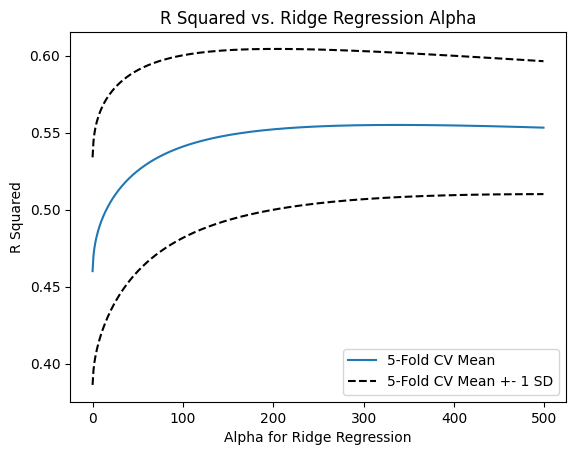

In [95]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

cv_means = []
cv_stds = []
for ridge_coeff in np.arange(0.05, 500, 1):
  multi_pred_ridge_standardized = Ridge(ridge_coeff).fit(all_features_array_scaled[train_and_validate_indices, :], labels.iloc[train_and_validate_indices]['sknt'].values.reshape(-1, 1))
  multi_pred_ridge_standardized_cv = cross_val_score(multi_pred_ridge_standardized, all_features_array_scaled[train_and_validate_indices, :], labels.iloc[train_and_validate_indices]['sknt'].values.reshape(-1, 1))
  cv_means.append(multi_pred_ridge_standardized_cv.mean())
  cv_stds.append(multi_pred_ridge_standardized_cv.std())

cv_means = np.array(cv_means)
cv_stds = np.array(cv_stds)

plt.plot(np.arange(0.05, 500, 1), cv_means, label = '5-Fold CV Mean')
plt.plot(np.arange(0.05, 500, 1), cv_means + cv_stds, '--k', label = "5-Fold CV Mean +- 1 SD")
plt.plot(np.arange(0.05, 500, 1), cv_means - cv_stds, '--k')
plt.xlabel('Alpha for Ridge Regression')
plt.ylabel('R Squared')
plt.title('R Squared vs. Ridge Regression Alpha')
plt.legend()

multi_pred_ridge_standardized = Ridge(300).fit(all_features_array_scaled[train_and_validate_indices, :], labels.iloc[train_and_validate_indices]['sknt'].values.reshape(-1, 1))
multi_pred_ridge_standardized_cv = cross_val_score(multi_pred_ridge_standardized, all_features_array_scaled[train_and_validate_indices, :], labels.iloc[train_and_validate_indices]['sknt'].values.reshape(-1, 1))
multi_pred_ridge_standardized_trainonly = Ridge(300).fit(all_features_array_scaled[train_indices, :], labels.iloc[train_indices]['sknt'].values.reshape(-1, 1))
multi_pred_ridge_standardized_validscore = multi_pred_ridge_standardized_trainonly.score(all_features_array_scaled[validate_indices, :], labels.iloc[validate_indices]['sknt'].values.reshape(-1, 1))

print(("Cross-validation mean R squared: " + str(multi_pred_ridge_standardized_cv.mean())))
print(("Cross-validation stdev R squared: " + str(multi_pred_ridge_standardized_cv.std())))
print(("Validation set R squared is: " + str(multi_pred_ridge_standardized_validscore)))

In [96]:
#Do bootstrap to estimate prediction variance
bootstrap_pred_scores = []
bootstrap_w = []
for iter in range(50):
  bootstrap_indices = []
  for i in range(int(round(len(train_indices) / 2))):
    bootstrap_indices.append(train_indices[np.random.randint(0, len(train_indices))])
  bootstrap_indices = np.array(bootstrap_indices)
  multi_pred_ridge_standardized = Ridge(400).fit(all_features_array_scaled[bootstrap_indices, :], labels.iloc[bootstrap_indices]['sknt'].values.reshape(-1, 1))
  score = multi_pred_ridge_standardized.score(all_features_array_scaled[validate_indices, :], labels.iloc[validate_indices]['sknt'].values.reshape(-1, 1))
  bootstrap_pred_scores.append(score)
  bootstrap_w.append(multi_pred_ridge_standardized.coef_[0])
  
print('Mean of bootstrapped R squared is: ' + str(np.array(bootstrap_pred_scores).mean()))
print('StDev of bootstrapped R squared is: ' + str(np.array(bootstrap_pred_scores).std()))

Mean of bootstrapped R squared is: 0.491011615702576
StDev of bootstrapped R squared is: 0.022111489993068494


In [97]:
np.array(bootstrap_w).std(axis = 0)

array([0.08166554, 0.06980939, 0.07135491, 0.0774171 , 0.07442107,
       0.0759324 , 0.07192269, 0.08286886, 0.08244919, 0.11357536,
       0.07475247, 0.09041457, 0.08410696, 0.10140909, 0.0797291 ,
       0.08255587, 0.09131585, 0.09848301, 0.08653881, 0.05983766,
       0.08403399, 0.08696335, 0.06805313, 0.06782027, 0.06509449,
       0.07657426, 0.0856037 , 0.10795636, 0.11671752, 0.1001865 ,
       0.08026984, 0.09840393, 0.0788969 , 0.07282404, 0.08865209,
       0.08910275, 0.08060726, 0.08212356, 0.07847809, 0.07255868,
       0.08909762, 0.06198081, 0.06803881, 0.07999897, 0.08672634,
       0.08768117, 0.0875319 , 0.08525016, 0.07844623, 0.0723051 ,
       0.08638215, 0.07594146, 0.0851937 , 0.08236449, 0.09059542,
       0.06719405, 0.0638908 , 0.08105774, 0.0765251 , 0.08605562,
       0.06660337, 0.07752326, 0.06254057, 0.09384153, 0.0812356 ,
       0.06796511, 0.06221549, 0.0769029 , 0.07951428, 0.06928385,
       0.08391015, 0.08225008, 0.08828312, 0.06385651, 0.06281

Text(0.5, 1.0, 'All-predictor Ridge Regression Predicted vs. Actual Wind Speed \n Standardized Features')

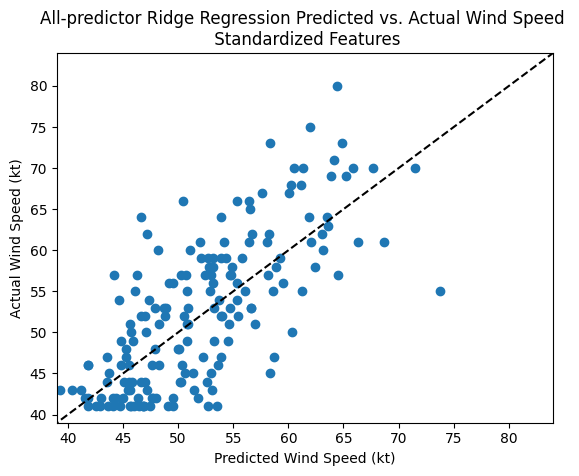

In [89]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

multi_pred_ridge_standardized = Ridge(500).fit(all_features_array_scaled[train_indices], labels.iloc[train_indices]['sknt'].values.reshape(-1, 1))
multi_pred_ridge_standardized_predictions = multi_pred_ridge_standardized.predict(all_features_array_scaled[validate_indices])

plt.scatter(multi_pred_ridge_standardized_predictions, labels.iloc[validate_indices]['sknt'].values.reshape(-1, 1))
plt.plot([0, 85], [0, 85], '--k')
plt.ylim([39, 84])
plt.xlim([39, 84])


plt.xlabel('Predicted Wind Speed (kt)')
plt.ylabel('Actual Wind Speed (kt)')
plt.title('All-predictor Ridge Regression Predicted vs. Actual Wind Speed \n Standardized Features')

Text(0.5, 1.0, 'All-Feature Ridge Regression (alpha = 500) with Standardized Data: \n Coefficient Magnitudes')

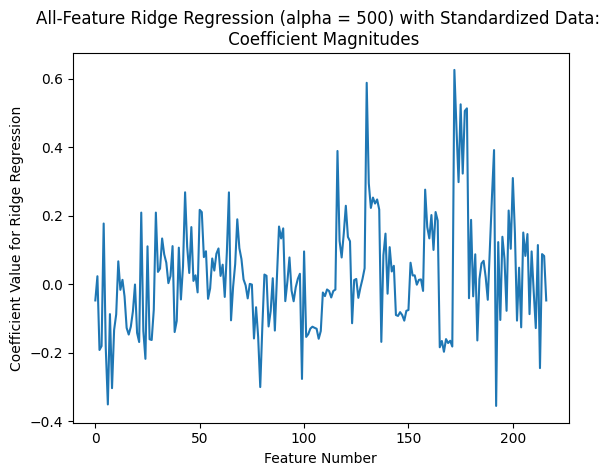

In [99]:
plt.plot(multi_pred_ridge_standardized.coef_[0])
plt.xlabel('Feature Number')
plt.ylabel('Coefficient Value for Ridge Regression')
plt.title('All-Feature Ridge Regression (alpha = 500) with Standardized Data: \n Coefficient Magnitudes')

All-Predictors Lasso Regression Linear Model for Standardized Data, L1 Regularization

0.05
0.1
0.15000000000000002
0.2
0.25
0.3
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.6500000000000001
0.7000000000000001
0.7500000000000001
0.8
0.8500000000000001
0.9000000000000001
0.9500000000000001
1.0
1.05
1.1
1.1500000000000001
1.2000000000000002
1.2500000000000002
1.3
1.35
1.4000000000000001
1.4500000000000002
1.5000000000000002
1.55
1.6
1.6500000000000001
1.7000000000000002
1.7500000000000002
1.8
1.85
1.9000000000000001
1.9500000000000002
2.0
2.05
2.1
2.15
2.1999999999999997
2.25
2.3
2.35
2.4
2.45
2.5
2.55
2.6
2.65
2.7
2.75
2.8
2.85
2.9
2.95
3.0
3.05
3.1
3.15
3.2
3.25
3.3
3.35
3.4
3.45
3.5
3.55
3.6
3.65
3.7
3.75
3.8
3.85
3.9
3.95
4.0
4.05
4.1
4.15
4.2
4.25
4.3
4.35
4.4
4.45
4.5
4.55
4.6
4.65
4.7
4.75
4.8
4.8500000000000005
4.9
4.95
Cross-validation mean R squared: 0.5300651216638892
Cross-validation stdev R squared: 0.029739842822322223
Validation set R squared is: 0.52813066664242


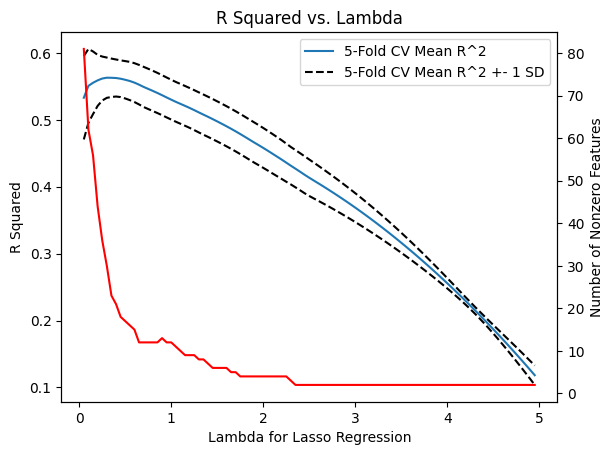

In [98]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

cv_means = []
cv_stds = []
nonzeros = []
for lasso_coeff in np.arange(0.05, 5, 0.05):
  print(lasso_coeff)
  multi_pred_lasso_standardized = Lasso(lasso_coeff).fit(all_features_array_scaled[train_and_validate_indices, :], labels.iloc[train_and_validate_indices]['sknt'].values.reshape(-1, 1))
  multi_pred_lasso_standardized_cv = cross_val_score(multi_pred_lasso_standardized, all_features_array_scaled[train_and_validate_indices, :], labels.iloc[train_and_validate_indices]['sknt'].values.reshape(-1, 1))
  cv_means.append(multi_pred_lasso_standardized_cv.mean())
  cv_stds.append(multi_pred_lasso_standardized_cv.std())
  nonzeros.append((abs(multi_pred_lasso_standardized.coef_) > 0).sum())

cv_means = np.array(cv_means)
cv_stds = np.array(cv_stds)

fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(0.05, 5, 0.05), cv_means, label = '5-Fold CV Mean R^2')
ax.plot(np.arange(0.05, 5, 0.05), cv_means + cv_stds, '--k', label = "5-Fold CV Mean R^2 +- 1 SD")
ax.plot(np.arange(0.05, 5, 0.05), cv_means - cv_stds, '--k')
ax2 = ax.twinx()
ax2.plot(np.arange(0.05, 5, 0.05), nonzeros, 'r', label = 'Nonzero Features')
ax2.set_ylabel("Number of Nonzero Features")

ax.set_xlabel('Lambda for Lasso Regression')
ax.set_ylabel('R Squared')
plt.title('R Squared vs. Lambda')
#plt.legend(loc = 'center right')
ax.legend()

multi_pred_lasso_standardized = Lasso(1).fit(all_features_array_scaled[train_and_validate_indices, :], labels.iloc[train_and_validate_indices]['sknt'].values.reshape(-1, 1))
multi_pred_lasso_standardized_cv = cross_val_score(multi_pred_lasso_standardized, all_features_array_scaled[train_and_validate_indices, :], labels.iloc[train_and_validate_indices]['sknt'].values.reshape(-1, 1))
multi_pred_lasso_standardized_trainonly = Lasso(1).fit(all_features_array_scaled[train_indices, :], labels.iloc[train_indices]['sknt'].values.reshape(-1, 1))
multi_pred_lasso_standardized_validscore = multi_pred_lasso_standardized_trainonly.score(all_features_array_scaled[validate_indices, :], labels.iloc[validate_indices]['sknt'].values.reshape(-1, 1))

print(("Cross-validation mean R squared: " + str(multi_pred_lasso_standardized_cv.mean())))
print(("Cross-validation stdev R squared: " + str(multi_pred_lasso_standardized_cv.std())))
print(("Validation set R squared is: " + str(multi_pred_lasso_standardized_validscore)))

Text(0.5, 1.0, 'All-Feature Lasso Regression (lambda = 0.6) with Standardized Data: \n Coefficient Magnitudes')

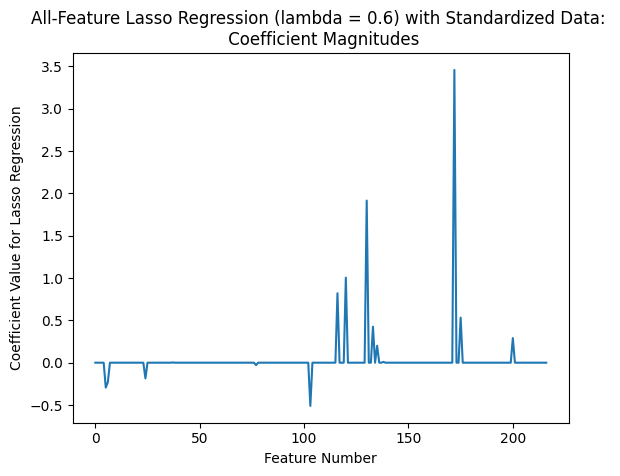

In [92]:
plt.plot(multi_pred_lasso_standardized.coef_)
plt.xlabel('Feature Number')
plt.ylabel('Coefficient Value for Lasso Regression')
plt.title('All-Feature Lasso Regression (lambda = 0.6) with Standardized Data: \n Coefficient Magnitudes')

In [93]:
multi_pred_lasso_standardized.coef_[120]

1.0049863599727327

In [94]:
features.columns.values[120]

'usfc5'